In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-data/Full Final.csv


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# 1.1 Load Data
# Update this path for Kaggle: "../input/<dataset-name>/Full Final.csv"
file_path = "/kaggle/input/my-data/Full Final.csv" 
df = pd.read_csv(file_path)

# 1.2 Keep only needed columns
cols_to_keep = ['Temp_C', 'Temp_F', 'SpO2', 'BPM', 'Anomaly']
df = df[cols_to_keep]

# 1.3 Basic Inspection
print("Initial Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe(include='all'))

Initial Shape: (6696, 5)
  Temp_C Temp_F  SpO2   BPM   Anomaly
0  33.86  92.95  97.0  51.0  Abnormal
1  33.86  92.95  97.0  72.0    Normal
2  33.86  92.95  97.0  72.0    Normal
3  33.92  93.06  97.0  72.0    Normal
4  33.92  93.06  98.0  72.0    Normal
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6696 entries, 0 to 6695
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Temp_C   6696 non-null   object 
 1   Temp_F   6696 non-null   object 
 2   SpO2     6513 non-null   float64
 3   BPM      6690 non-null   float64
 4   Anomaly  6696 non-null   object 
dtypes: float64(2), object(3)
memory usage: 261.7+ KB
None
       Temp_C Temp_F         SpO2          BPM   Anomaly
count    6696   6696  6513.000000  6690.000000      6696
unique    194    194          NaN          NaN         2
top     36.36  97.45          NaN          NaN  Abnormal
freq      338    338          NaN          NaN      4546
mean      NaN    NaN    93.5865

In [12]:
# 2.1 String to Numeric Cleaning
def clean_numeric_str(x):
    if isinstance(x, str):
        # Keep only digits, dots, plus, and minus
        clean_txt = re.sub(r'[^\d\.\+\-]', '', x)
        return clean_txt
    return x

for col in ['Temp_C', 'Temp_F']:
    df[col] = df[col].apply(clean_numeric_str)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2.2 Convert SpO2 and BPM to numeric
for col in ['SpO2', 'BPM']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2.3 Null Value Check
print("\nMissing values before cleaning:")
print(df.isna().sum())

# 2.4 Duplicate Rows
initial_rows = len(df)
df = df.drop_duplicates()
print(f"\nDuplicates dropped: {initial_rows - len(df)}")

# 2.5 Outlier Handling for SpO2
# Cap SpO2 at 100%
df.loc[df['SpO2'] > 100, 'SpO2'] = 100
# Remove rows with SpO2 < 50 (likely sensor errors/disconnects)
mask_low_spo2 = df['SpO2'] < 50
print(f"Rows dropped due to SpO2 < 50: {mask_low_spo2.sum()}")
df = df[~mask_low_spo2]

# 2.6 Class-wise Missing Value Imputation
# We impute using the median of the specific Anomaly class to avoid data distortion
for col in ['SpO2', 'BPM', 'Temp_C', 'Temp_F']:
    df[col] = df[col].fillna(df.groupby('Anomaly')[col].transform('median'))
    # Fill any remaining (if a class is fully empty) with global median
    df[col] = df[col].fillna(df[col].median())

# 2.7 Final Sanity Check
print("\nFinal Data Info:")
print(df.info())


Missing values before cleaning:
Temp_C       0
Temp_F       0
SpO2       183
BPM          6
Anomaly      0
dtype: int64

Duplicates dropped: 2773
Rows dropped due to SpO2 < 50: 7

Final Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3916 entries, 0 to 6497
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Temp_C   3916 non-null   float64
 1   Temp_F   3916 non-null   float64
 2   SpO2     3916 non-null   float64
 3   BPM      3916 non-null   float64
 4   Anomaly  3916 non-null   object 
dtypes: float64(4), object(1)
memory usage: 183.6+ KB
None


3. Class Distribution & Basic Plots

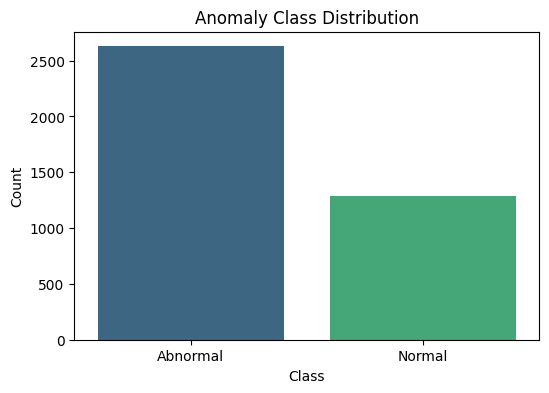

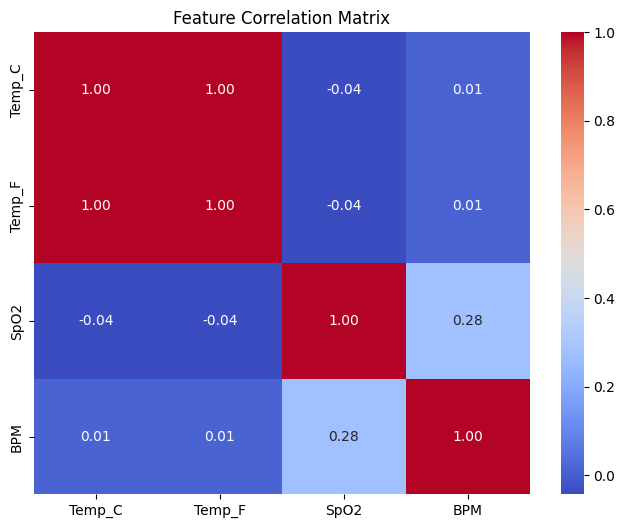

In [13]:
# 3.1 Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Anomaly', data=df, palette='viridis')
plt.title('Anomaly Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 3.2 Correlation Matrix
# We map Anomaly to numeric temporarily for correlation checking
df_corr = df.copy()
df_corr['Anomaly_Code'] = df_corr['Anomaly'].astype('category').cat.codes

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr[['Temp_C', 'Temp_F', 'SpO2', 'BPM']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

4. Train–Test Split & SMOTE

In [14]:
!pip install --upgrade scikit-learn imbalanced-learn

In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 4.1 Encode Target
target_mapping = {'Normal': 0, 'Abnormal': 1}
df['Anomaly_Encoded'] = df['Anomaly'].map(target_mapping)
print(f"Target Mapping: {target_mapping}")

# 4.2 Define Features and Target
X = df[['Temp_C', 'Temp_F', 'SpO2', 'BPM']]
y = df['Anomaly_Encoded']

# 4.3 Split Data (Stratified to maintain ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4.4 Class Balancing with SMOTE (Training set only)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE (Train):", y_train.value_counts().to_dict())
print("Class distribution after SMOTE (Train):", y_train_bal.value_counts().to_dict())

Target Mapping: {'Normal': 0, 'Abnormal': 1}
Class distribution before SMOTE (Train): {1: 2101, 0: 1031}
Class distribution after SMOTE (Train): {1: 2101, 0: 2101}


5. Model Training, Cross-Validation, and Evaluation

Model                | Accuracy   | F1 Score   | ROC-AUC   
------------------------------------------------------------
LogisticRegression   | 0.7932     | 0.7861     | 0.8442
RandomForest         | 0.9574     | 0.9574     | 0.9930
GradientBoosting     | 0.9462     | 0.9449     | 0.9892

Best Model Selected: RandomForest

--- Test Set Report ---
              precision    recall  f1-score   support

      Normal       0.94      0.91      0.93       258
    Abnormal       0.96      0.97      0.97       526

    accuracy                           0.95       784
   macro avg       0.95      0.94      0.95       784
weighted avg       0.95      0.95      0.95       784



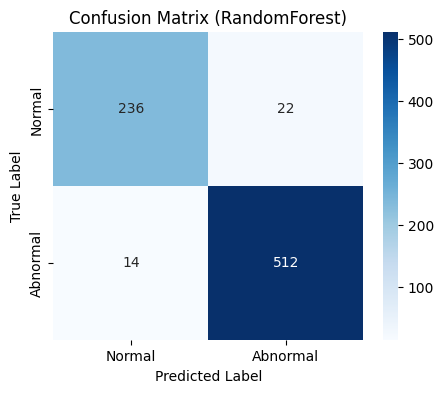

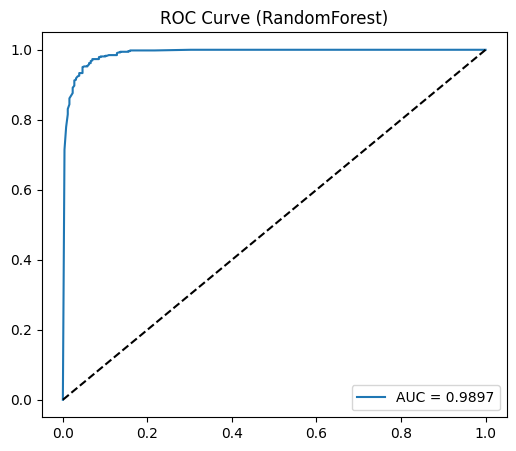

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Define models
models = {
    "LogisticRegression": Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', LogisticRegression(random_state=42))
    ]),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# 5.2 Cross-Validation
print(f"{'Model':<20} | {'Accuracy':<10} | {'F1 Score':<10} | {'ROC-AUC':<10}")
print("-" * 60)

best_model_name = ""
best_score = 0
cv_results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='f1').mean()
    auc = cross_val_score(model, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc').mean()
    
    print(f"{name:<20} | {acc:.4f}     | {f1:.4f}     | {auc:.4f}")
    
    if f1 > best_score:
        best_score = f1
        best_model_name = name

print(f"\nBest Model Selected: {best_model_name}")

# 5.3 Fit Best Model on full balanced training data
best_model = models[best_model_name]
best_model.fit(X_train_bal, y_train_bal)

# 5.4 Evaluation on Test Set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n--- Test Set Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title(f'Confusion Matrix ({best_model_name})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_val = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f'ROC Curve ({best_model_name})')
plt.legend()
plt.show()

6. Model Interpretation & Journal Notes

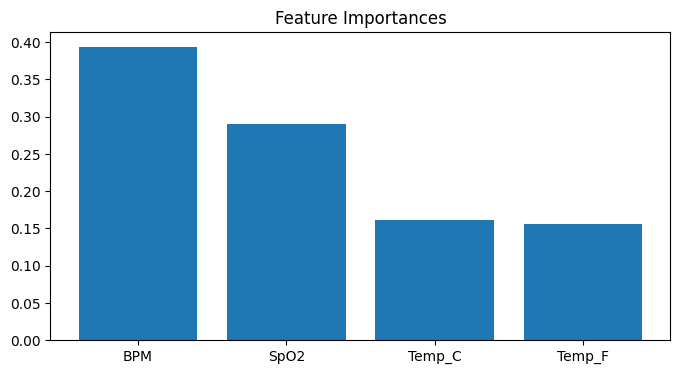

In [17]:
# 6.1 Feature Importance
if best_model_name in ['RandomForest', 'GradientBoosting']:
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns
    
    plt.figure(figsize=(8, 4))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), features[indices])
    plt.show()

In [18]:
#Step 1: Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Define Parameter Grids
# Random Forest Hyperparameters
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Gradient Boosting Hyperparameters
param_dist_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# 2. Run Randomized Search (Tuning)
print("Tuning Random Forest...")
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_distributions=param_dist_rf, 
    n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1, scoring='f1'
)
rf_random.fit(X_train_bal, y_train_bal)
best_rf = rf_random.best_estimator_
print(f"Best Random Forest Params: {rf_random.best_params_}")

print("\nTuning Gradient Boosting...")
gb_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), 
    param_distributions=param_dist_gb, 
    n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1, scoring='f1'
)
gb_random.fit(X_train_bal, y_train_bal)
best_gb = gb_random.best_estimator_
print(f"Best Gradient Boosting Params: {gb_random.best_params_}")

Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}

Tuning Gradient Boosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Gradient Boosting Params: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2}


In [19]:
#Step 2: Create & Train the Proposed Ensemble
# 3. Create Voting Classifier (Soft Voting)
# Soft voting predicts the class with the highest summed probability
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf), 
        ('gb', best_gb)
    ], 
    voting='soft'
)

# Train the Ensemble on the balanced data
print("\nTraining Proposed Ensemble Model...")
voting_clf.fit(X_train_bal, y_train_bal)
print("Training Complete.")


Training Proposed Ensemble Model...
Training Complete.



--- Proposed Model (Voting Ensemble) Performance ---
              precision    recall  f1-score   support

      Normal       0.96      0.92      0.94       258
    Abnormal       0.96      0.98      0.97       526

    accuracy                           0.96       784
   macro avg       0.96      0.95      0.96       784
weighted avg       0.96      0.96      0.96       784

Final F1 Score: 0.9718
Final ROC-AUC:  0.9917


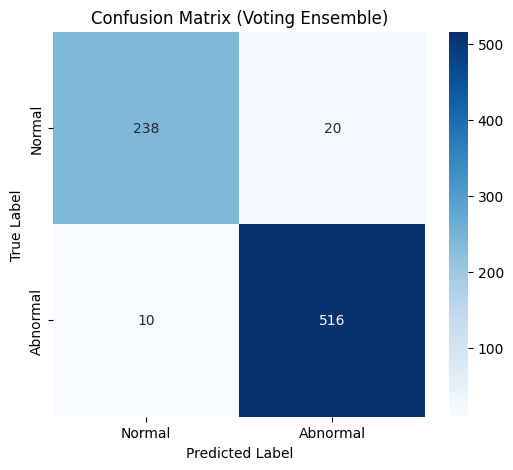

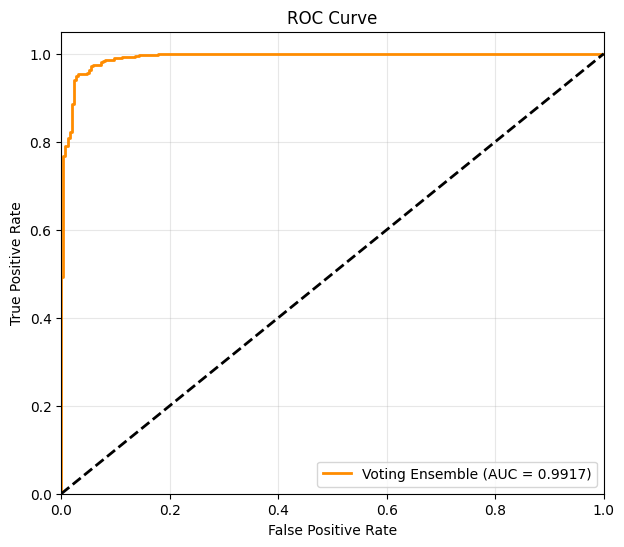

In [20]:
#Step 3: Comprehensive Evaluation (Journal-Ready Plots)
# 4. Evaluate on Test Set
y_pred_final = voting_clf.predict(X_test)
y_proba_final = voting_clf.predict_proba(X_test)[:, 1]

print("\n--- Proposed Model (Voting Ensemble) Performance ---")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Abnormal']))

# Calculate specific metrics for the paper
f1 = f1_score(y_test, y_pred_final)
auc_score = roc_auc_score(y_test, y_proba_final)
print(f"Final F1 Score: {f1:.4f}")
print(f"Final ROC-AUC:  {auc_score:.4f}")

# --- Plot 1: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix (Voting Ensemble)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- Plot 2: ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba_final)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'Voting Ensemble (AUC = {auc_score:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
#Step 4: Save the Final Model
# Save the trained ensemble model
joblib.dump(voting_clf, 'proposed_voting_model.pkl')
print("Success: Proposed model saved as 'proposed_voting_model.pkl'")

Success: Proposed model saved as 'proposed_voting_model.pkl'


In [23]:
import joblib
import pandas as pd
import numpy as np

# 1. Load the saved model
# This simulates a production environment where the model is already trained
try:
    loaded_model = joblib.load('proposed_voting_model.pkl')
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: Model file not found. Make sure you ran the previous step to save it.")

# 2. Create Sample Data (Simulating New Patients)
# Patient A: Healthy vitals (36.6°C, 98% SpO2, 75 BPM)
# Patient B: Abnormal vitals (38.5°C, 88% SpO2, 110 BPM) -> Fever + Low Oxygen
new_data = pd.DataFrame([
    [36.6, 97.88, 98, 75], 
    [38.5, 101.3, 88, 110]
], columns=['Temp_C', 'Temp_F', 'SpO2', 'BPM'])

print("\n--- New Patient Data ---")
print(new_data)

# 3. Make Predictions
predictions = loaded_model.predict(new_data)
probs = loaded_model.predict_proba(new_data)

# 4. Display Results
class_map = {0: 'Normal', 1: 'Abnormal'}

print("\n--- Prediction Results ---")
for i, (pred, prob) in enumerate(zip(predictions, probs)):
    status = class_map[pred]
    confidence = prob[pred] * 100 # Probability of the predicted class
    
    print(f"Patient {chr(65+i)}: Prediction = {status} (Confidence: {confidence:.2f}%)")
    
    if status == 'Abnormal':
        print(f"   -> ALERT: Patient {chr(65+i)} requires immediate attention!")

Model loaded successfully.

--- New Patient Data ---
   Temp_C  Temp_F  SpO2  BPM
0    36.6   97.88    98   75
1    38.5  101.30    88  110

--- Prediction Results ---
Patient A: Prediction = Normal (Confidence: 100.00%)
Patient B: Prediction = Abnormal (Confidence: 100.00%)
   -> ALERT: Patient B requires immediate attention!
